In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import pymongo
import os
import sys
import re
import time

import botorch
from botorch.models.transforms.input import AffineInputTransform
from botorch.models import SingleTaskGP, MultiTaskGP
from botorch.fit import fit_gpytorch_model

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel, ProductKernel

# Load and visuzalize the data from database

In [2]:
# Open credential file for database
with open(os.path.join(os.getenv('HOME'), 'db.profile')) as f:
    db_profile = f.read()

# Connect to the MongoDB database with read-only access
db = pymongo.MongoClient(
    host="mongodb05.nersc.gov",
    username="bella_sf_ro",
    password=re.findall('SF_DB_READONLY_PASSWORD=(.+)', db_profile)[0],
    authSource="bella_sf")["bella_sf"]

In [3]:
# print names of collections
for collection_name in db.list_collection_names():
    print(collection_name)

acave
config
ip2


In [4]:
ip2_collection=db["ip2"]
# for doc in ip2_collection.find():
#     print(doc)

In [5]:
#Extract simulation and experiment data for ip2 studies
experiment_data = ip2_collection.find({"experiment_flag":1})
df_exp = pd.DataFrame(list(experiment_data))

simulation_data = ip2_collection.find({"experiment_flag":0})
df_sim = pd.DataFrame(list(simulation_data))

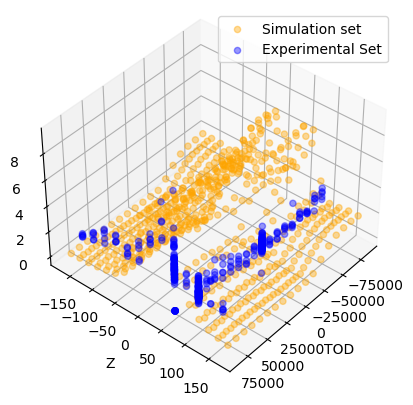

In [6]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_sim['TOD_fs3'], df_sim['z_target_um'],
           df_sim['n_protons'], c='orange', alpha=0.4, label='Simulation set')
ax.scatter( df_exp['TOD_fs3'], df_exp['z_target_um'],
           df_exp['n_protons'], c='b', alpha=0.4, label='Experimental Set')
ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('TOD')
ax.set_ylabel('Z')
ax.set_zlabel('Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

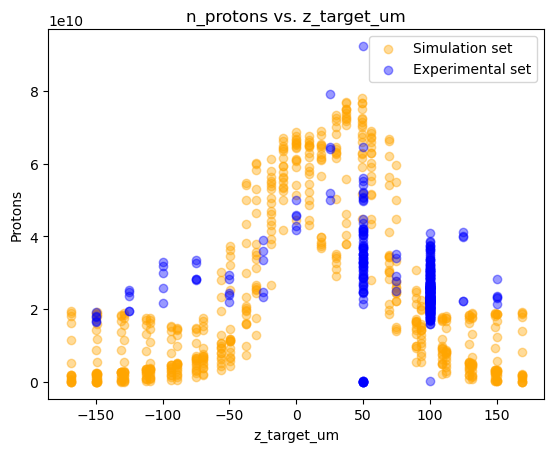

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter( df_sim['z_target_um'],
           df_sim['n_protons'], c='orange', alpha=0.4, label='Simulation set')
ax.scatter(  df_exp['z_target_um'],
           df_exp['n_protons'], c='b', alpha=0.4, label='Experimental set')

ax.set_title('n_protons vs. z_target_um')
# Set labels and title
ax.set_xlabel('z_target_um')
ax.set_ylabel('Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

# Define the input and output normalizations, based on the experimental data set

In [8]:
# Define the input and output normalizations, based on the experimental data set
X = torch.tensor(df_exp[['z_target_um', 'TOD_fs3', 'GVD']].values, dtype=torch.float)
input_transform_exp = AffineInputTransform(3, coefficient=X.std(axis=0), offset=X.mean(axis=0))

y = torch.tensor(df_exp['n_protons'].values, dtype=torch.float).reshape(-1,1)
output_transform_exp = AffineInputTransform( 1, coefficient=y.std(axis=0), offset=y.mean(axis=0))

# Normalized both simulation and experimental data sets

In [9]:
norm_sim_data = df_sim.copy()
norm_sim_data[['z_target_um', 'TOD_fs3', 'GVD']] = input_transform_exp( torch.tensor( df_sim[['z_target_um', 'TOD_fs3', 'GVD']].values ) )
norm_sim_data[['n_protons']] = output_transform_exp( torch.tensor( df_sim[['n_protons']].values.reshape(-1,1) ) )

norm_exp_data = df_exp.copy()
norm_exp_data[['z_target_um', 'TOD_fs3', 'GVD']] = input_transform_exp( torch.tensor( df_exp[['z_target_um', 'TOD_fs3', 'GVD']].values ) )
norm_exp_data[['n_protons']] = output_transform_exp( torch.tensor( df_exp[['n_protons']].values.reshape(-1,1) ) )

# Visualize normalized data sets

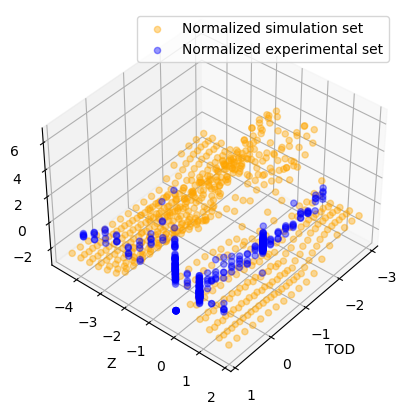

In [10]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(norm_sim_data['TOD_fs3'], norm_sim_data['z_target_um'],
           norm_sim_data['n_protons'], c='orange', alpha=0.4, label='Normalized simulation set')
ax.scatter(norm_exp_data['TOD_fs3'], norm_exp_data['z_target_um'],
           norm_exp_data['n_protons'], c='b', alpha=0.4, label='Normalized experimental set')
ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('TOD')
ax.set_ylabel('Z')
ax.set_zlabel('Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

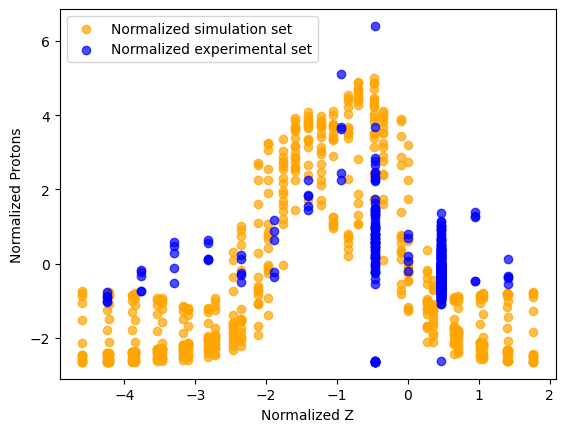

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(norm_sim_data['z_target_um'],
           norm_sim_data['n_protons'], c='orange', alpha=0.7, label='Normalized simulation set')
ax.scatter(norm_exp_data['z_target_um'],
           norm_exp_data['n_protons'], c='blue', alpha=0.7, label='Normalized experimental set')
# Set labels and title
ax.set_xlabel('Normalized Z')
ax.set_ylabel('Normalized Protons')

# Add legend
ax.legend()
# Show plot
plt.show()


# Define a multi-input multi-task GP model

In [12]:
def multi_input_multi_task_gp(x_sim_list, y_sim, x_train_list, y_train):
    """
    Multi-task Gaussian Process model that supports any number of input features.

    Parameters:
    - x_sim_list: List of tensors representing simulated input features.
    - y_sim: Tensor of simulated output values.
    - x_train_list: List of tensors representing experimental input features.
    - y_train: Tensor of experimental output values.

    Returns:
    - Trained MultiTaskGP model.
    """
    
    gp_kernel = ScaleKernel(RBFKernel())
    
    # Create task-specific input features (0 for simulated, 1 for real experiments)
    x_sim_task = torch.cat([torch.zeros((x_sim_list.shape[0], 1)), x_sim_list], dim=1)
    x_train_task = torch.cat([torch.ones((x_train_list.shape[0], 1)), x_train_list], dim=1)

    # Define the multi-task GP model
    model = MultiTaskGP(
        torch.cat([x_sim_task, x_train_task], dim=0),  # Combined input data
        torch.cat([y_sim, y_train], dim=0),  # Combined output data
        task_feature=0,  # Task identifier at index 0
        covar_module=gp_kernel  # Kernel function
    )

    # Fit the model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    return model

In [13]:
z_sim = torch.tensor(norm_sim_data[['z_target_um']].values)
TOD_sim = torch.tensor(norm_sim_data[['TOD_fs3']].values)
protons_sim = torch.tensor(norm_sim_data[['n_protons']].values)
GVD_sim = torch.tensor(norm_sim_data[['GVD']].values)

z_exp = torch.tensor(norm_exp_data[['z_target_um']].values)
TOD_exp = torch.tensor(norm_exp_data[['TOD_fs3']].values)
protons_exp = torch.tensor(norm_exp_data[['n_protons']].values)
GVD_exp = torch.tensor(norm_exp_data[['GVD']].values)

sim_tr_list = torch.tensor(norm_sim_data[['z_target_um', 'TOD_fs3', 'GVD']].values)
exp_tr_list = torch.tensor(norm_exp_data[['z_target_um', 'TOD_fs3', 'GVD']].values)

In [20]:
# Start the timer
start_time = time.time()
gp_model = multi_input_multi_task_gp(sim_tr_list, protons_sim, exp_tr_list, protons_exp)
# Stop the timer
end_time = time.time()

# Compute the time taken
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

zmin  = min( np.min(z_sim.numpy()), np.min(z_exp.numpy()))
zmax  = max( np.max(z_sim.numpy()), np.max(z_exp.numpy()))
print('Simulation data: (zmin,zmin) = (', zmin, ',', zmax, ')')

tod_min  = min( np.min(TOD_sim.numpy()), np.min(TOD_exp.numpy()))
tod_max  = max( np.max(TOD_sim.numpy()), np.max(TOD_exp.numpy()))
print('Simulation data: (tod_min,tod_max) = (', tod_min, ',', tod_max, ')')

gvd_min  = min( np.min(GVD_sim.numpy()), np.min(GVD_exp.numpy()))
gvd_max  = max( np.max(GVD_sim.numpy()), np.max(GVD_exp.numpy()))
print('Simulation data: (gvd_min, gvd_max) = (', gvd_min, ',', gvd_max, ')')

z_test_array = torch.tensor (np.linspace(zmin,zmax,100).reshape(-1, 1), dtype=torch.float32) 
TOD_test_array  = torch.tensor (np.linspace(tod_min,tod_max,100).reshape(-1, 1), dtype=torch.float32) 
GVD_test_array  = torch.tensor (np.linspace(gvd_min,gvd_max,100).reshape(-1, 1), dtype=torch.float32) 

predictions_on_train = gp_model.posterior(torch.cat([z_exp, TOD_exp, GVD_exp], dim=1) )

predictions = gp_model.posterior( torch.cat([z_test_array, TOD_test_array, GVD_test_array], dim=1) )

# Get confidence interval with respect to the task
# First column ([:, 0]) represents the lower bound of the 95% confidence interval for the first task (e.g., simulated data).
# Second column ([:, 1])represents the lower bound of the 95% confidence interval for the second task (e.g., experimental data).
lower_bound_sim = predictions.confidence_region()[0].detach().numpy()[:,0]
upper_bound_sim = predictions.confidence_region()[1].detach().numpy()[:,0]

lower_bound_exp = predictions.confidence_region()[0].detach().numpy()[:,1]
upper_bound_exp = predictions.confidence_region()[1].detach().numpy()[:,1]

Training Time: 1.68 seconds
Simulation data: (zmin,zmin) = ( -4.59359840628207 , 1.765173988755917 )
Simulation data: (tod_min,tod_max) = ( -2.903977138438927 , 0.8431422420120791 )
Simulation data: (gvd_min, gvd_max) = ( -3.577729517072414 , 3.5776885734416712 )


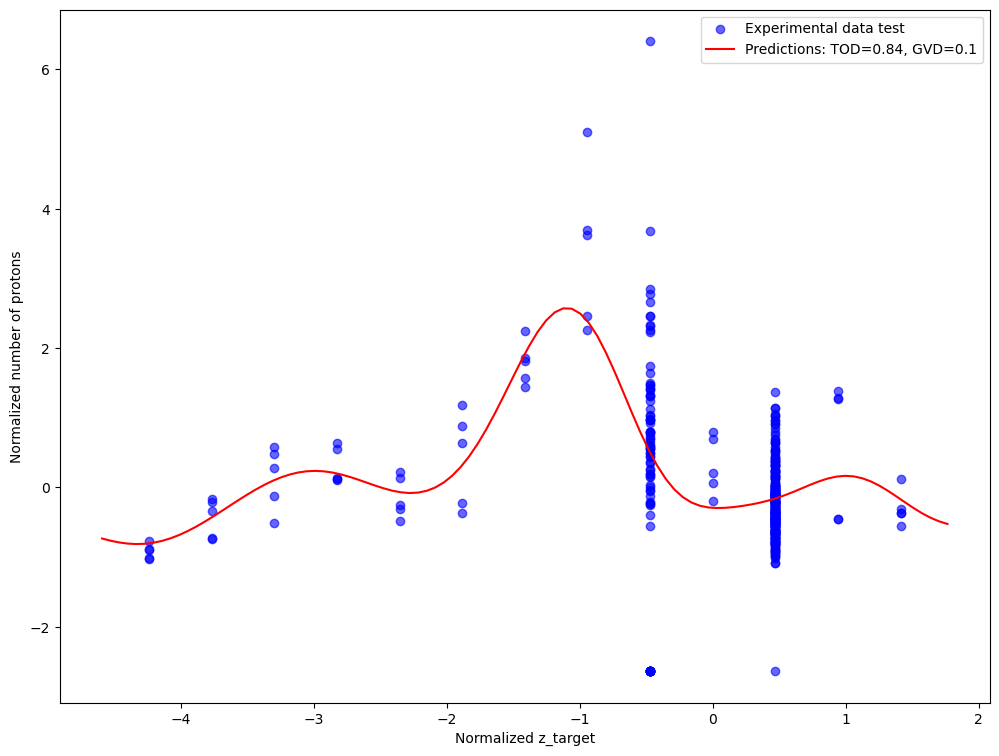

In [21]:
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(z_exp, protons_exp, label='Experimental data test', alpha=0.6, color = 'blue')
plt.legend()
for fixed_tod_val in [tod_max]:#np.linspace(0,tod_max, 3):
    for fixed_gvd_val in [0.1]:#np.linspace(0,0,3):
        TOD_test_array  = torch.tensor (np.linspace(fixed_tod_val,fixed_tod_val,100).reshape(-1, 1), dtype=torch.float32) 
        GVD_test_array  = torch.tensor (np.linspace(fixed_gvd_val,fixed_gvd_val,100).reshape(-1, 1), dtype=torch.float32) 

        predictions = gp_model.posterior( torch.cat([z_test_array, TOD_test_array, GVD_test_array], dim=1) )
        
        plt.plot(z_test_array.numpy(),predictions.mean[:,1].detach().numpy(),  c='r', label = 'Predictions: TOD='+ str(np.round(fixed_tod_val,2)) +', GVD='+ str(np.round(fixed_gvd_val,2)) )
        plt.xlabel('Normalized z_target')
        plt.ylabel('Normalized number of protons')
        plt.legend()

# Visualize predictions along with confidence interval for the first task (simulation data)

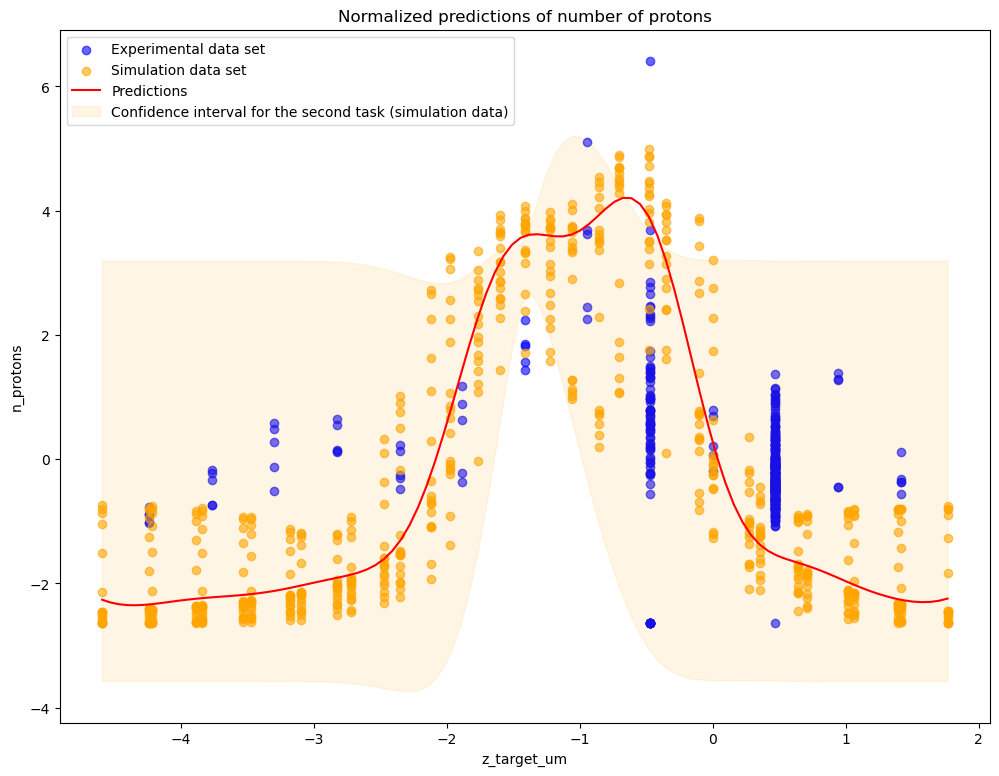

In [22]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(z_exp, protons_exp, label='Experimental data set', alpha=0.6, color = 'blue')
ax.scatter(z_sim, protons_sim, label='Simulation data set', alpha=0.6, color = 'orange')

plt.plot(z_test_array.numpy(),predictions.mean[:,0].detach().numpy(), label='Predictions', c='r' )
plt.fill_between(z_test_array.numpy().flatten(), lower_bound_sim, upper_bound_sim, color='orange', alpha=0.1, label='Confidence interval for the second task (simulation data)')

plt.title("Normalized predictions of number of protons")
plt.xlabel('z_target_um')
plt.ylabel('n_protons')
plt.savefig('./' + 'n_protons_predictions_split_zval__' + '.png')
plt.legend()

# Visualize predictions along with confidence interval for the second task (experimental data)

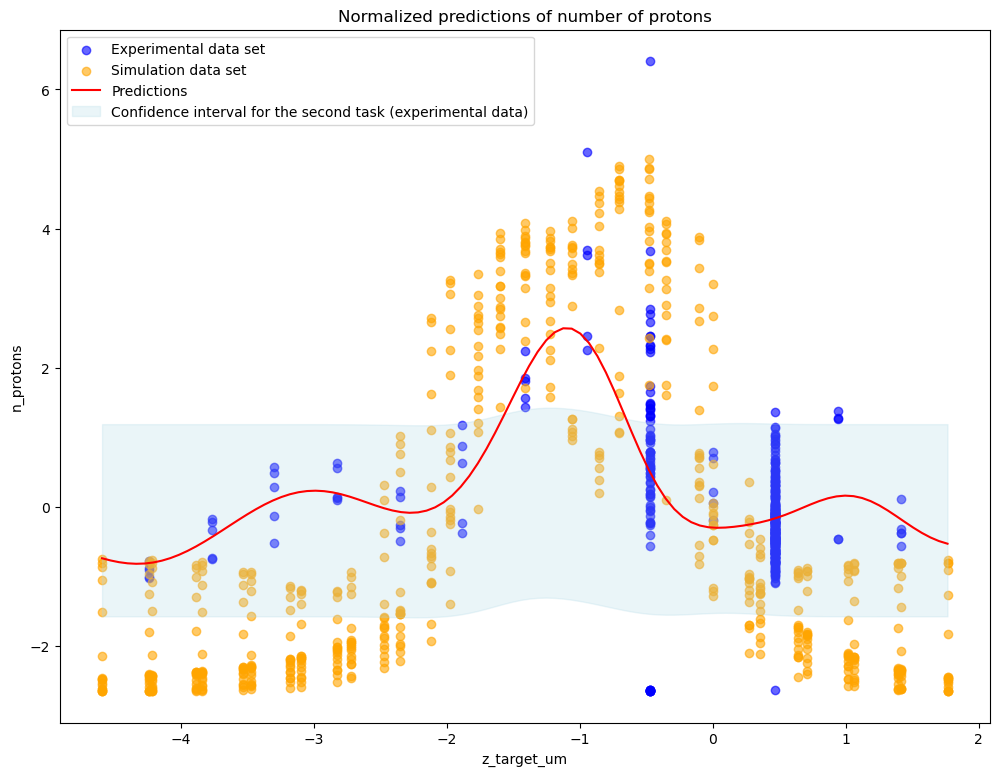

In [23]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(z_exp, protons_exp, label='Experimental data set', alpha=0.6, color = 'blue')
ax.scatter(z_sim, protons_sim, label='Simulation data set', alpha=0.6, color = 'orange')

plt.plot(z_test_array.numpy(),predictions.mean[:,1].detach().numpy(), label='Predictions', c='r' )
plt.fill_between(z_test_array.numpy().flatten(), lower_bound_exp, upper_bound_exp, color='lightblue', alpha=0.25, label='Confidence interval for the second task (experimental data)')

plt.title("Normalized predictions of number of protons")
plt.xlabel('z_target_um')
plt.ylabel('n_protons')
plt.savefig('./' + 'n_protons_predictions_split_zval__' + '.png')
plt.legend()